In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Step 1: Load the dataset
df = pd.read_csv("day.csv")  # Ensure 'day.csv' is in the same directory

In [3]:
# Step 2: Drop unnecessary columns
df.drop(columns=['casual', 'registered'], inplace=True)

In [4]:
# Step 3: Convert categorical variables
season_dict = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
df['season'] = df['season'].map(season_dict)

weather_dict = {1: 'Clear', 2: 'Mist', 3: 'Light Snow/Rain', 4: 'Heavy Rain/Snow'}
df['weathersit'] = df['weathersit'].map(weather_dict)

In [5]:
# Step 4: Convert categorical variables into one-hot encoding
df = pd.get_dummies(df, columns=['season', 'weathersit'], drop_first=True)


In [6]:
# Step 5: Fix categorical plotting issues
# Identify season-related columns dynamically
season_columns = [col for col in df.columns if col.startswith('season_')]

# Create a new column to store the most relevant season label
if season_columns:
    df['season_category'] = df[season_columns].idxmax(axis=1).str.replace('season_', '')
else:
    df['season_category'] = 'Unknown'  # Fallback if no season columns exist

# Identify weather-related columns dynamically
weather_columns = [col for col in df.columns if col.startswith('weathersit_')]

# Create a new column to store the most relevant weather label
if weather_columns:
    df['weather_category'] = df[weather_columns].idxmax(axis=1).str.replace('weathersit_', '')
else:
    df['weather_category'] = 'Unknown'


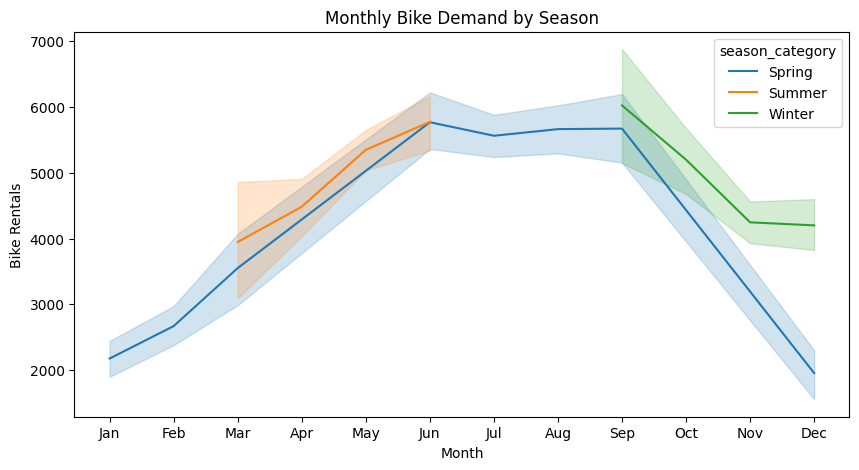

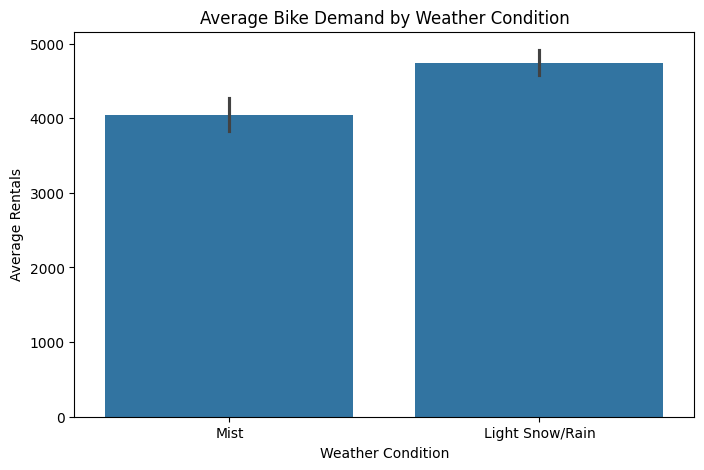

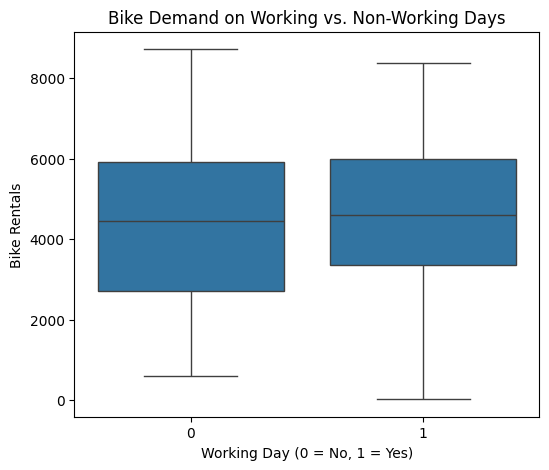

In [7]:
# Step 6: Exploratory Data Analysis (EDA)
# Visualizing monthly bike demand by season
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='mnth', y='cnt', hue='season_category')
plt.title("Monthly Bike Demand by Season")
plt.xlabel("Month")
plt.ylabel("Bike Rentals")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Visualizing weather impact
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='weather_category', y='cnt', estimator=np.mean)
plt.title("Average Bike Demand by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Average Rentals")
plt.show()

# Visualizing weekend vs weekday demand
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='workingday', y='cnt')
plt.title("Bike Demand on Working vs. Non-Working Days")
plt.xlabel("Working Day (0 = No, 1 = Yes)")
plt.ylabel("Bike Rentals")
plt.show()

In [8]:
# Step 7: Train-test split
X = df.drop(columns=['cnt', 'dteday', 'instant', 'season_category', 'weather_category'])  # Drop non-numeric columns
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Step 8: Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# Step 9: Train the Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [11]:
# Step 10: Model Evaluation
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R-squared Score: 0.8521
Mean Squared Error: 506297.02
Root Mean Squared Error: 711.55


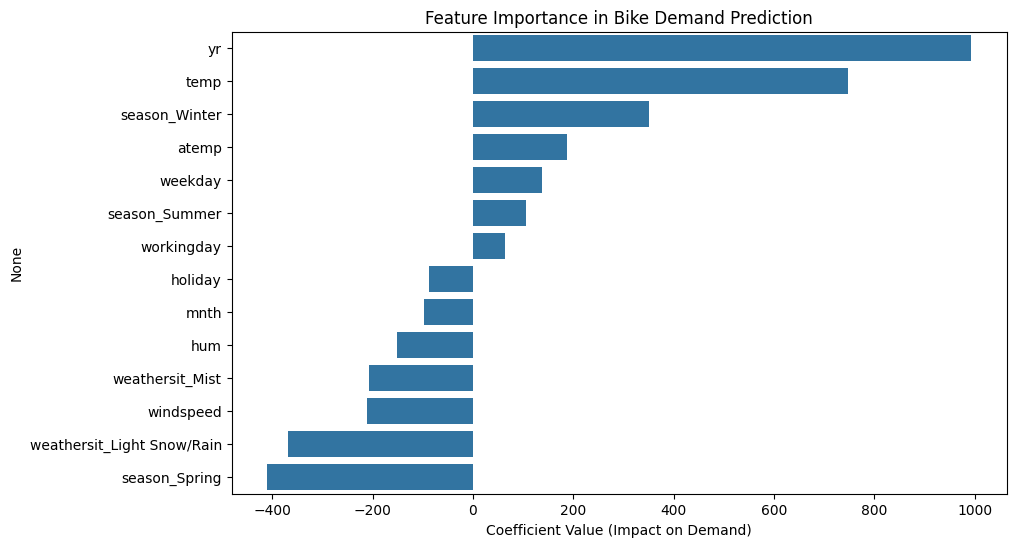

In [12]:
# Step 11: Feature Importance Analysis
feature_importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance in Bike Demand Prediction")
plt.xlabel("Coefficient Value (Impact on Demand)")
plt.show()

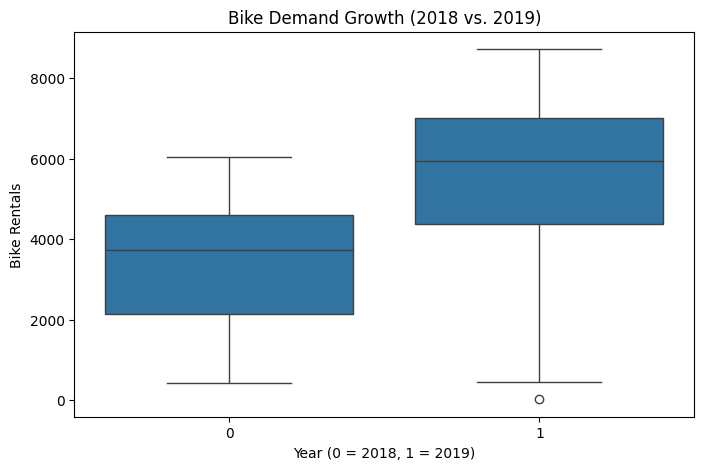

In [13]:
# Step 12: Year-over-Year Growth Analysis
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='yr', y='cnt')
plt.title("Bike Demand Growth (2018 vs. 2019)")
plt.xlabel("Year (0 = 2018, 1 = 2019)")
plt.ylabel("Bike Rentals")
plt.show()

In [14]:
# Step 13: What-If Analysis (Predicting Demand under Different Conditions)
def predict_demand(temp, humidity, windspeed, season_fall, weather_light_snow_rain):
    """
    Predicts bike demand based on input weather and seasonal conditions.

    Parameters:
    - temp: Scaled temperature value
    - humidity: Scaled humidity value
    - windspeed: Scaled wind speed value
    - season_fall: Binary value for season (1 if Fall, 0 otherwise)
    - weather_light_snow_rain: Binary value for weather condition (1 if Light Snow/Rain, 0 otherwise)

    Returns:
    - Predicted bike demand
    """
    # Create an input DataFrame with columns matching X_train
    input_data = pd.DataFrame(columns=X_train.columns)  
    input_data.loc[0] = 0  # Initialize all values to 0

    # Set only the relevant features with provided values
    input_data.at[0, 'temp'] = temp
    input_data.at[0, 'hum'] = humidity
    input_data.at[0, 'windspeed'] = windspeed
    
    # Check if 'season_Fall' exists before setting its value
    if 'season_Fall' in input_data.columns:
        input_data.at[0, 'season_Fall'] = season_fall
    
    # Check if 'weathersit_Light Snow/Rain' exists before setting its value
    if 'weathersit_Light Snow/Rain' in input_data.columns:
        input_data.at[0, 'weathersit_Light Snow/Rain'] = weather_light_snow_rain

    # Scale the input data using the same StandardScaler fitted earlier
    input_data_scaled = scaler.transform(input_data)

    # Predict bike demand
    predicted_demand = model.predict(input_data_scaled)
    return round(predicted_demand[0])

# Example: Predict demand if temperature is 30°C, humidity is 50%, windspeed is 10
print("Predicted Bike Demand:", predict_demand(0.6, 0.5, 0.1, 1, 0))

Predicted Bike Demand: 2250
/tmp/ipykernel_318/1375718951.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.at[0, 'temp'] = temp
/tmp/ipykernel_318/1375718951.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.at[0, 'hum'] = humidity
/tmp/ipykernel_318/1375718951.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.at[0, 'windspeed'] = windspeed


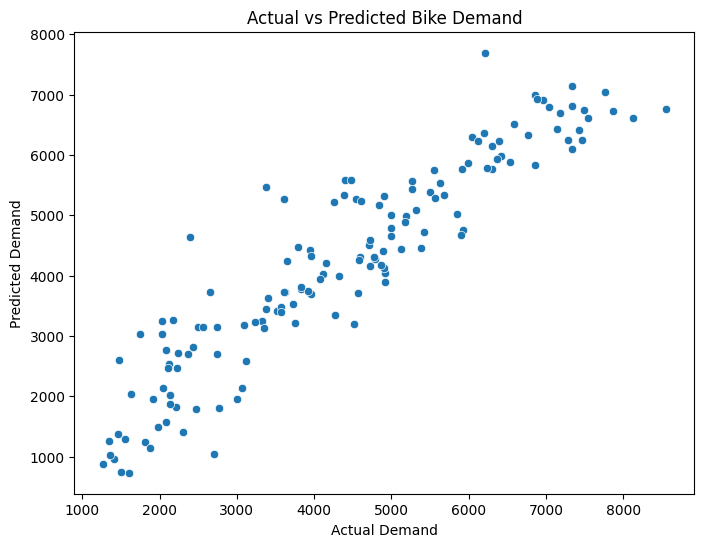

In [15]:
# Step 14: Actual vs Predicted Values Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Bike Demand")
plt.show()


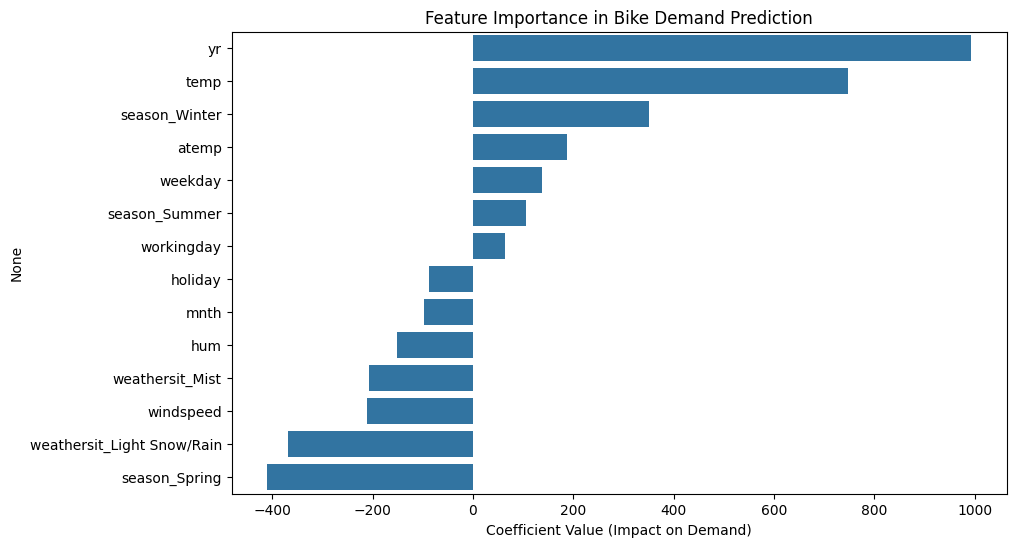

In [16]:
# Step 15: Feature Importance Analysis

# Displaying the impact of each feature on bike demand

feature_importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance in Bike Demand Prediction")
plt.xlabel("Coefficient Value (Impact on Demand)")
plt.show()


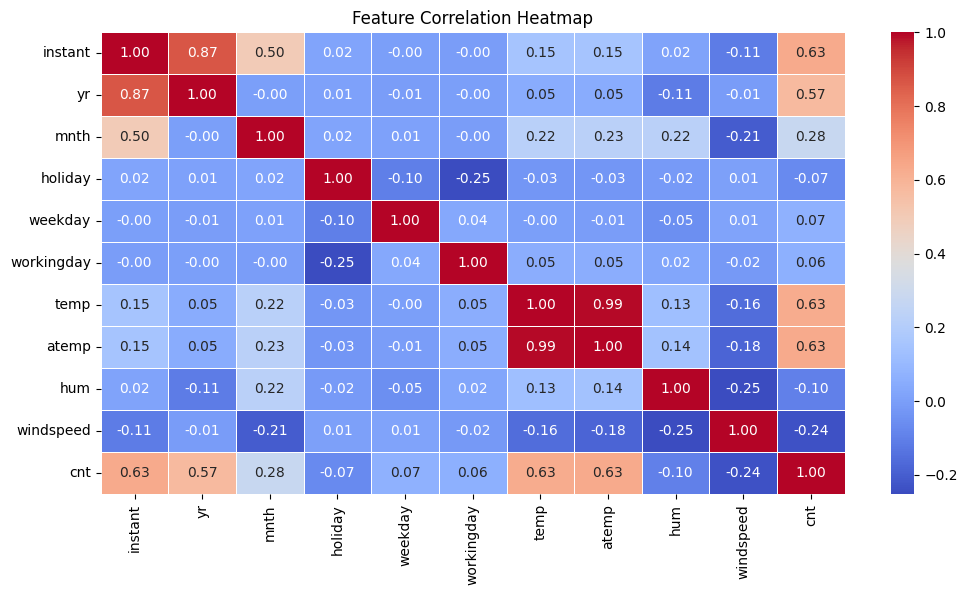

Top Features Correlated with Bike Demand:
 cnt           1.000000
atemp         0.630685
instant       0.629896
temp          0.627044
yr            0.569728
mnth          0.278191
weekday       0.067534
workingday    0.062542
holiday      -0.068764
hum          -0.098543
windspeed    -0.235132
Name: cnt, dtype: float64


In [17]:
# Step 16: Correlation Analysis
df_corr = df.select_dtypes(include=[np.number])
correlation_matrix = df_corr.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

correlation_with_target = correlation_matrix["cnt"].sort_values(ascending=False)
print("Top Features Correlated with Bike Demand:\n", correlation_with_target)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=24756760-bd48-49cc-91e4-c4043dfa8e70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>